In [394]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import mutual_info_regression


In [395]:
main_folder = "/Users/hanouf/Desktop/timeSeries_fuzzyLogic/AZTD/AZT1D 2025/CGM Records"
dfs = []
subject_counter = 1

for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            try:
                df = pd.read_csv(file_path)
                df.insert(0, 'Subject_ID', subject_counter)
                dfs.append(df)
                subject_counter += 1
            except Exception as e:
                print(f"Error: {file_path}: {e}")

merged = pd.concat(dfs, ignore_index=True)

In [396]:
print(merged.columns.tolist())

['Subject_ID', 'EventDateTime', 'DeviceMode', 'BolusType', 'Basal', 'CorrectionDelivered', 'TotalBolusInsulinDelivered', 'FoodDelivered', 'CarbSize', 'CGM', 'Readings (CGM / BGM)']


In [397]:
merged["CGM"] = merged["CGM"].fillna(merged["Readings (CGM / BGM)"])

In [398]:
num_nulls = merged['CGM'].isna().sum()
num_nulls

0

In [399]:
merged.isnull().sum()

Subject_ID                         0
EventDateTime                      0
DeviceMode                    239283
BolusType                     287778
Basal                         105823
CorrectionDelivered           287778
TotalBolusInsulinDelivered    287778
FoodDelivered                 287778
CarbSize                      287778
CGM                                0
Readings (CGM / BGM)          293709
dtype: int64

In [400]:
merged['EventDateTime'] = pd.to_datetime(merged['EventDateTime'])
diffs = merged['EventDateTime'].diff().dropna()
print(diffs.value_counts().head())

EventDateTime
0 days 00:05:00    241473
0 days 00:04:59     21515
0 days 00:05:01     19710
0 days 00:00:00      5789
0 days 00:05:02      5040
Name: count, dtype: int64


In [401]:
num_rows = len(merged)
generated_time = pd.date_range(start='2024-01-01 00:00:00', periods=num_rows, freq='5min')
merged['EventDateTime'] = generated_time

In [402]:
diffs = merged['EventDateTime'].diff().dropna()
print(diffs.value_counts().head())

EventDateTime
0 days 00:05:00    306711
Name: count, dtype: int64


In [403]:
def detect_outliers_iqr(series, factor=1.5):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    q1, q3 = valid.quantile([0.25, 0.75])
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return pd.Series(False, index=series.index)
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = ~series.between(lower, upper, inclusive='both')
    return mask.fillna(False)

In [404]:
def detect_outliers_zscore(series, threshold=3.0):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    mean = valid.mean()
    std = valid.std(ddof=0)
    if pd.isna(std) or std == 0:
        return pd.Series(False, index=series.index)
    z = (series - mean) / std
    mask = z.abs() > threshold
    return mask.fillna(False)

In [405]:
#choose numeric columns
numeric_df = merged.select_dtypes('number')

In [406]:
#per-column counts
outlier_rows = []
for col in numeric_df.columns:                      # iterate columns explicitly
    s = merged[col]
    m_iqr = detect_outliers_iqr(s)
    m_z   = detect_outliers_zscore(s)
    outlier_rows.append({
        'column': col,
        'iqr_count': int(m_iqr.sum()),
        'z_count':   int(m_z.sum()),
        'iqr_pct':   round(m_iqr.mean() * 100, 2),
        'z_pct':     round(m_z.mean()   * 100, 2),
    })

outlier_df = pd.DataFrame(outlier_rows).set_index('column')

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_13452/3154530168.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')


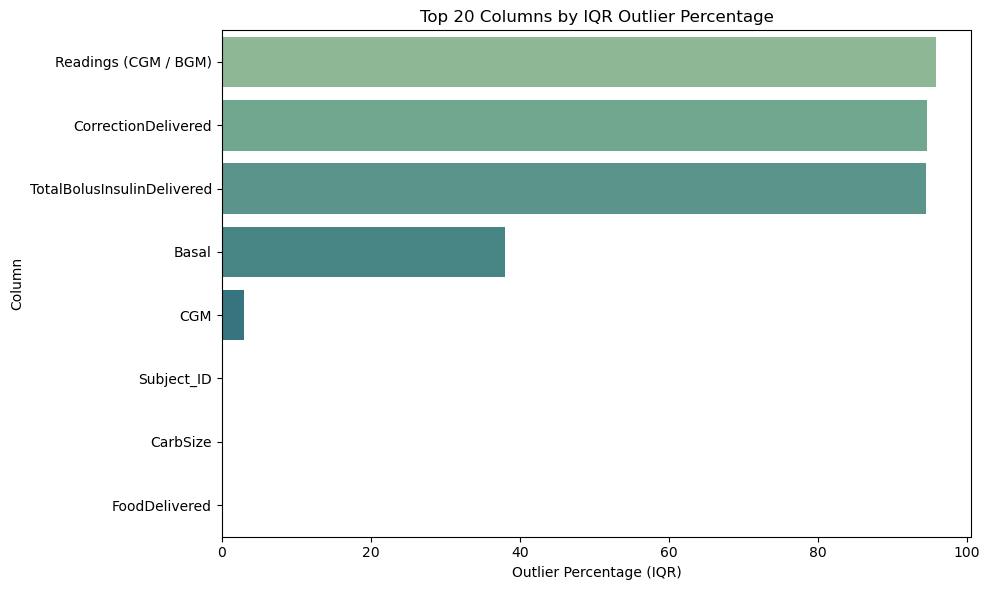

In [407]:
#top by IQR 
top_iqr = outlier_df.sort_values('iqr_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')
plt.title('Top 20 Columns by IQR Outlier Percentage')
plt.xlabel('Outlier Percentage (IQR)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()


/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_13452/805936563.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')


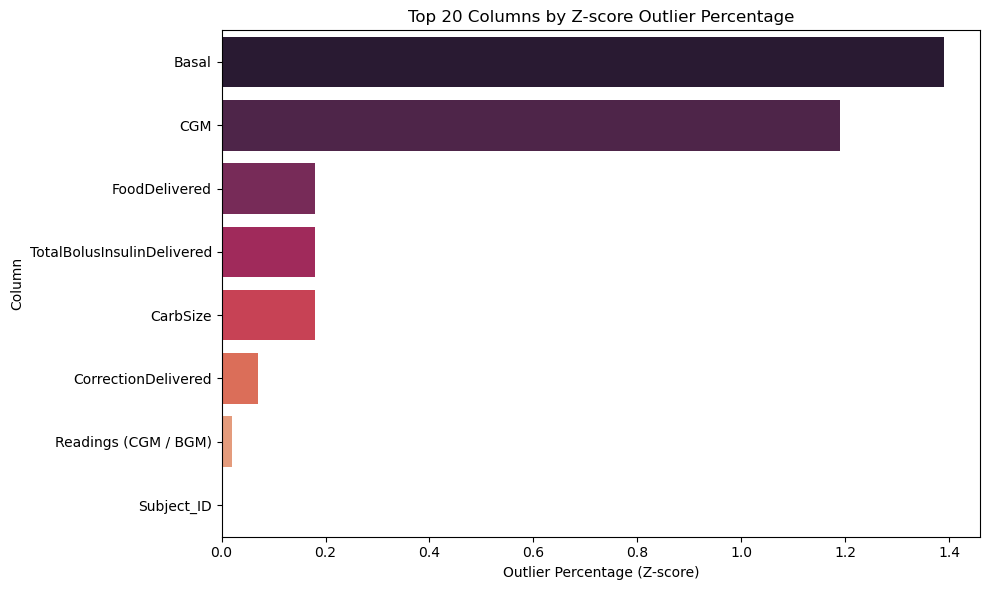

In [408]:
#top by Z-score 
top_z = outlier_df.sort_values('z_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')
plt.title('Top 20 Columns by Z-score Outlier Percentage')
plt.xlabel('Outlier Percentage (Z-score)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

In [409]:
df = merged.copy()

OUTLIER REMOVAL FOR AZT1D DATASET
==================================
Paper Section III.A mentions: "Basal rates and device modes are extracted 
from PDFs using OCR" - this process is error-prone and can introduce outliers.

WHY NOT USE IQR/Z-SCORE?
- Data is sparse: 93.8% of Bolus/Carb values are NaN (events, not continuous)
- IQR/Z-score assume normal distribution (not true for event-based data)
- Would incorrectly flag all insulin/meal events as outliers
- so we will Use clinical domain knowledge instead


In [410]:
print(f"\nMax values before cleaning:")
print(f"  Basal: {df['Basal'].max():.2f} units/hr")
print(f"  Bolus: {df['TotalBolusInsulinDelivered'].max():.2f} units")
print(f"  CGM:   {df['CGM'].max():.2f} mg/dL")
print(f"  Carbs: {df['CarbSize'].max():.2f} grams")


Max values before cleaning:
  Basal: 4127.00 units/hr
  Bolus: 25.00 units
  CGM:   400.00 mg/dL
  Carbs: 120.00 grams


CLINICAL THRESHOLDS:
1. Basal: 0-10 units/hr (typical: 0.5-2.5, extreme: ~5, >10 = OCR errors)
2. Bolus: 0-30 units (typical meal: 5-15, large meal: 20-25)
3. Carbs: 0-300 grams (typical: 30-100, extreme but valid: 200+)
4. CGM: 40-600 mg/dL (Dexcom G6 Pro sensor limits)

In [411]:
df_cleaned = df.copy()
#Set impossible values to NaN 
# (OCR errors from PDF extraction)
df_cleaned.loc[(df_cleaned['Basal'] < 0) | (df_cleaned['Basal'] > 10), 'Basal'] = np.nan

#(physiologically impossible doses)
df_cleaned.loc[(df_cleaned['TotalBolusInsulinDelivered'] < 0) | 
               (df_cleaned['TotalBolusInsulinDelivered'] > 30), 'TotalBolusInsulinDelivered'] = np.nan

#(impossible amounts)
df_cleaned.loc[(df_cleaned['CarbSize'] < 0) | (df_cleaned['CarbSize'] > 300), 'CarbSize'] = np.nan

In [412]:
df_cleaned['Basal'] = df_cleaned.groupby('Subject_ID')['Basal'].ffill()

WHY SET TO NaN INSTEAD OF REMOVING ROWS?
- This is TIME SERIES data - removing rows breaks temporal continuity

In [413]:
print(f"\nMax values after cleaning:")
print(f"  Basal: {df_cleaned['Basal'].max():.2f} units/hr")
print(f"  Bolus: {df_cleaned['TotalBolusInsulinDelivered'].max():.2f} units")
print(f"  CGM:   {df_cleaned['CGM'].max():.2f} mg/dL")
print(f"  Carbs: {df_cleaned['CarbSize'].max():.2f} grams")


Max values after cleaning:
  Basal: 10.00 units/hr
  Bolus: 25.00 units
  CGM:   400.00 mg/dL
  Carbs: 120.00 grams


In [414]:
# Report results
print(f"Original rows: {len(df):,}")
print(f"Cleaned rows:  {len(df_cleaned):,}")

Original rows: 306,712
Cleaned rows:  306,712


In [415]:
df = df_cleaned

The DELTA tells you the direction and speed of change.

In [417]:
df["delta_CGM"] = df.groupby("Subject_ID")["CGM"].diff().shift(1).fillna(0) # With shift delta tells you "how much CGM changed LAST TIME"
df["delta_CGM"] = df["delta_CGM"].clip(-50, 50).fillna(0)

In [418]:
df[['CGM','delta_CGM']].head()

,CGM,delta_CGM
0,91.0,0.0
1,88.0,0.0
2,85.0,-3.0
3,80.0,-3.0
4,77.0,-5.0


In [419]:
df.isnull().sum()

Subject_ID                         0
EventDateTime                      0
DeviceMode                    239283
BolusType                     287778
Basal                         103983
CorrectionDelivered           287778
TotalBolusInsulinDelivered    287778
FoodDelivered                 287778
CarbSize                      287778
CGM                                0
Readings (CGM / BGM)          293709
delta_CGM                          0
dtype: int64

In [420]:
df = df.fillna(0)

##  Pearson correlations

In [421]:
num_df = df.select_dtypes('number')

corr = num_df.corr()['CGM'].sort_values(ascending=False)

print("Top correlations with CGM:\n")
print(corr)

Top correlations with CGM:

CGM                           1.000000
Basal                         0.179294
delta_CGM                     0.122528
CorrectionDelivered           0.067934
TotalBolusInsulinDelivered    0.048695
FoodDelivered                 0.014296
CarbSize                      0.009868
Subject_ID                   -0.101831
Readings (CGM / BGM)         -0.136282
Name: CGM, dtype: float64


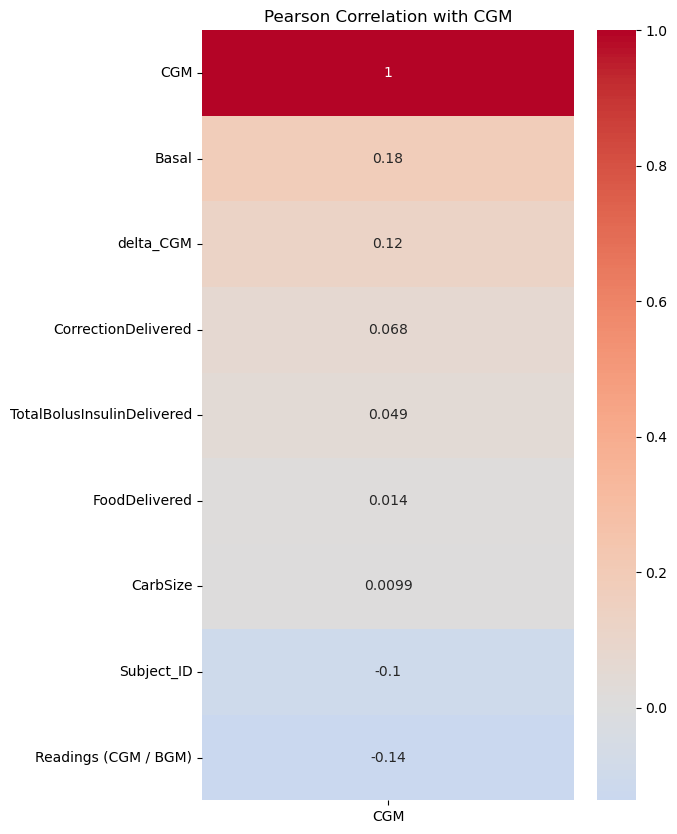

In [422]:
plt.figure(figsize=(6, 10))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Pearson Correlation with CGM")
plt.show()


## mutual information 

In [423]:
X = num_df.drop(columns=['CGM'])
y = num_df['CGM']

# compute mutual information (Information Gain)
mi = mutual_info_regression(X, y, random_state=42)

# put into a dataframe
mi_df = pd.DataFrame({'Feature': X.columns, 'Information_Gain': mi})
mi_df = mi_df.sort_values('Information_Gain', ascending=False)
# print top features
print(mi_df)

                      Feature  Information_Gain
1                       Basal          0.280057
6        Readings (CGM / BGM)          0.222584
0                  Subject_ID          0.185840
7                   delta_CGM          0.051801
3  TotalBolusInsulinDelivered          0.017374
2         CorrectionDelivered          0.013446
4               FoodDelivered          0.007807
5                    CarbSize          0.003623


/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_13452/4274187285.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df.head(15), x='Information_Gain', y='Feature', palette='viridis')


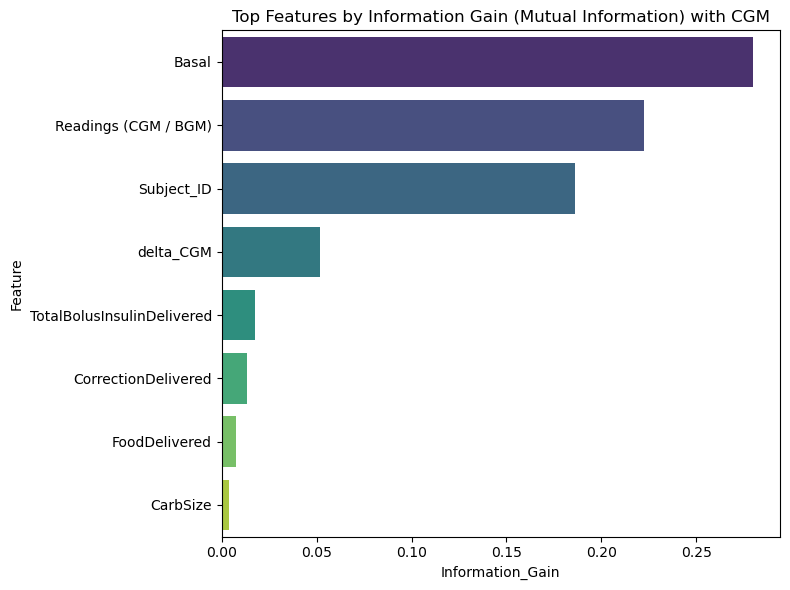

In [424]:
plt.figure(figsize=(8, 6))
sns.barplot(data=mi_df.head(15), x='Information_Gain', y='Feature', palette='viridis')
plt.title("Top Features by Information Gain (Mutual Information) with CGM")
plt.tight_layout()
plt.show()

In [425]:
s=mi_df.copy()
s["Information_Gain_Norm"] = s["Information_Gain"]/(s["Information_Gain"].max() or 1.0)
s

,Feature,Information_Gain,Information_Gain_Norm
1,Basal,0.280057,1.000000
6,Readings (CGM / BGM),0.222584,0.794781
0,Subject_ID,0.185840,0.663578
7,delta_CGM,0.051801,0.184964
3,TotalBolusInsulinDelivered,0.017374,0.062037
2,CorrectionDelivered,0.013446,0.048010
4,FoodDelivered,0.007807,0.027878
5,CarbSize,0.003623,0.012936



FEATURE SELECTION RATIONALE
============================
Based on the AZT1D dataset paper analysis:
we will INCLUDE:
- Basal: Set hourly before CGM reading means NO leakage
- TotalBolusInsulinDelivered: Past insulin affects future glucose
- CorrectionDelivered: Correction boluses influence next readings
- FoodDelivered: Meal insulin portion
- CarbSize: Direct impact on glucose

EXCLUDE:
- Subject_ID: Patient identity (use for grouping only, not as feature)
- Readings (CGM/BGM): Check if this is PAST readings or CURRENT 



In [426]:
#save dataset to CSV
output_path = "/Users/hanouf/Desktop/timeSeries_fuzzyLogic/AZTD/dataset.csv"
df.to_csv(output_path, index=False)